In [24]:
# Imports 
import os, PIL, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings; warnings.filterwarnings("ignore")

# Paths 
data_dir = r'C:/Users/Asus/Downloads/Tensor/New folder/seg_train/seg_train'
test_dir = r'C:/Users/Asus/Downloads/Tensor/New folder/seg_test/seg_test'
save_dir = r'C:/Users/Asus/Downloads/Tensor/New folder/Predicted_Images'

img_height, img_width = 224, 224
batch_size = 32
num_classes = 6  # buildings, forest, glacier, mountain, sea, street

os.makedirs(save_dir, exist_ok=True)


In [25]:
# Loading Data 

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


if set(os.listdir(test_dir)) == {'seg_test'}:
    test_dir = os.path.join(test_dir, 'seg_test')


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30, width_shift_range=0.10, height_shift_range=0.10,
    zoom_range=0.20, shear_range=0.10, horizontal_flip=True, fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)


train_gen = train_datagen.flow_from_directory(
    data_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='sparse',
    subset='training', shuffle=True
)


cls_order = list(train_gen.class_indices.keys())

val_gen = val_datagen.flow_from_directory(
    data_dir, target_size=(img_height, img_width),
    batch_size=1, class_mode='sparse',
    subset='validation', shuffle=True, classes=cls_order
)

test_gen = ImageDataGenerator(preprocess_input).flow_from_directory(
    test_dir, target_size=(img_height, img_width),
    batch_size=1, class_mode='sparse', shuffle=False, classes=cls_order
)


print("TRAIN:", train_gen.class_indices)
print("VAL  :", val_gen.class_indices)
print("TEST :", test_gen.class_indices)


idx_to_name = {v: k for k, v in train_gen.class_indices.items()}



Found 6430 images belonging to 6 classes.
Found 1604 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
TRAIN: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
VAL  : {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
TEST : {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [26]:
print("TRAIN:", train_gen.class_indices)
print("VAL  :", val_gen.class_indices)
print("TEST :", test_gen.class_indices)

TRAIN: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
VAL  : {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
TEST : {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [27]:
test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    test_dir, target_size=(img_height, img_width),
    batch_size=1, class_mode='sparse', shuffle=False
)


Found 3000 images belonging to 6 classes.


In [28]:
print("TEST :", test_gen.class_indices)


TEST : {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [29]:
# Model
base = tf.keras.applications.MobileNetV2(
    include_top=False, weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base.trainable = False  # first train the new head only

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.30)(x)  # light regularization
out = layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs=base.input, outputs=out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 114s 555ms/step - accuracy: 0.7637 - loss: 0.6372 - val_accuracy: 0.9800 - val_loss: 0.1525
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.4572 - val_accuracy: 0.8800 - val_loss: 0.4307
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 114s 569ms/step - accuracy: 0.8528 - loss: 0.3937 - val_accuracy: 0.9400 - val_loss: 0.2055
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9375 - loss: 0.2747 - val_accuracy: 0.9000 - val_loss: 0.4693


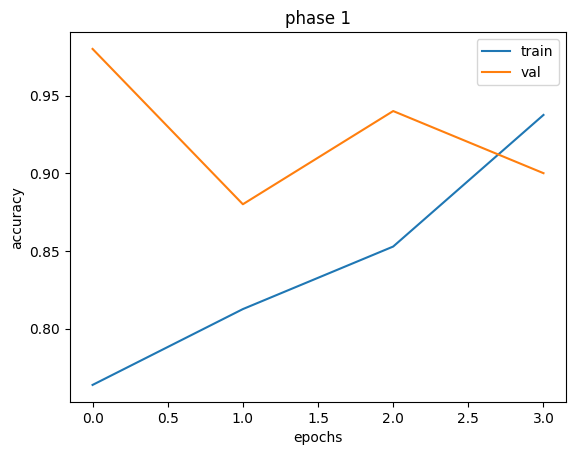

In [30]:
# training
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=3, restore_best_weights=True
)

history = model.fit(
    train_gen,
    epochs=10,  # start small; early stopping will halt if saturated
    validation_data=val_gen,
    steps_per_epoch=max(1, train_gen.samples // batch_size),
    validation_steps=max(1, val_gen.samples // batch_size),
    callbacks=[early],
    verbose=1
)

# quick curves 
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('epochs'); plt.ylabel('accuracy'); plt.title('phase 1')
plt.legend(); plt.show()


Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.6164 - loss: 1.0221
Epoch 1: val_accuracy improved from None to 0.86000, saving model to best_mnv2.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 167s 789ms/step - accuracy: 0.6366 - loss: 0.9752 - val_accuracy: 0.8600 - val_loss: 0.3664 - learning_rate: 1.0000e-06
Epoch 2/30
  1/200 ━━━━━━━━━━━━━━━━━━━━ 2:24 727ms/step - accuracy: 0.5625 - loss: 1.2032
Epoch 2: val_accuracy improved from 0.86000 to 0.92000, saving model to best_mnv2.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5625 - loss: 1.2032 - val_accuracy: 0.9200 - val_loss: 0.2527 - learning_rate: 1.0000e-06
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.6699 - loss: 0.9051
Epoch 3: val_accuracy did not improve from 0.92000
200/200 ━━━━━━━━━━━━━━━━━━━━ 188s 938ms/step - accuracy: 0.6851 - loss: 0.8622 - val_accuracy: 0.9200 - val_loss: 0.2227 - learning_rate: 1.0000e-06


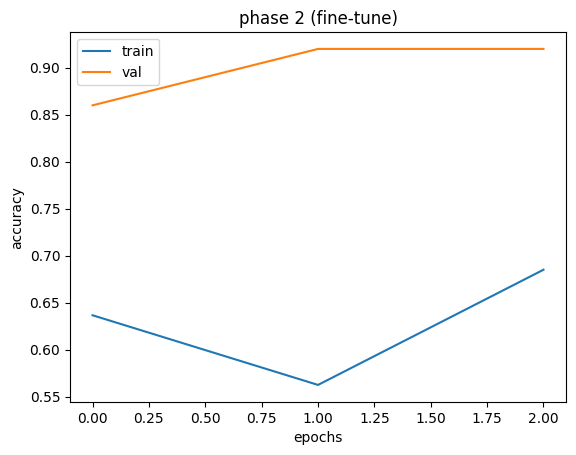

In [31]:
# fine-tuning 
base.trainable = True
for layer in base.layers[:-60]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),  # tiny LR for stable FT
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-7, verbose=1
)
ckpt = tf.keras.callbacks.ModelCheckpoint(
    'best_mnv2.keras', monitor='val_accuracy', mode='max',
    save_best_only=True, verbose=1
)

history_ft = model.fit(
    train_gen,
    epochs=30,  # you can stop earlier; early stopping will restore best
    validation_data=val_gen,
    steps_per_epoch=max(1, train_gen.samples // batch_size),
    validation_steps=max(1, val_gen.samples // batch_size),
    callbacks=[early, plateau, ckpt],
    verbose=1
)

plt.plot(history_ft.history['accuracy'], label='train')
plt.plot(history_ft.history['val_accuracy'], label='val')
plt.xlabel('epochs'); plt.ylabel('accuracy'); plt.title('phase 2 (fine-tune)')
plt.legend(); plt.show()


In [32]:
# Final evaluation
best_model = tf.keras.models.load_model('best_mnv2.keras')

# evaluate on val and test (this is the truth you report)
val_loss, val_acc = best_model.evaluate(val_gen, verbose=0)
test_loss, test_acc = best_model.evaluate(test_gen, verbose=0)
print(f"Final Val — Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
print(f"Final Test — Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

# save test images into folders of their predicted class
for cname in idx_to_name.values():
    os.makedirs(os.path.join(save_dir, cname), exist_ok=True)

test_gen.reset()
preds = best_model.predict(test_gen, verbose=0)

correct, total = 0, len(preds)
for i, prob in enumerate(preds):
    pred_idx = int(np.argmax(prob))
    true_idx = int(test_gen.labels[i])
    if pred_idx == true_idx:
        correct += 1

    img_path = test_gen.filepaths[i]
    img_name = os.path.basename(img_path)
    pred_name = idx_to_name[pred_idx]

    # save into predicted class folder
    try:
        PIL.Image.open(img_path).save(os.path.join(save_dir, pred_name, img_name))
    except Exception as e:
        # skip unreadable files but keep going
        print(f"skip {img_name}: {e}")

acc_pct = (correct / total) * 100 if total else 0.0
print("\n✅ Prediction Summary:")
print(f"   Total Images: {total}")
print(f"   Correct Predictions: {correct}")
print(f"   Wrong Predictions: {total - correct}")
print(f"   Final Accuracy: {acc_pct:.2f}%")
print(f"\n📁 Predicted images saved to: {save_dir}")


Final Val — Loss: 0.3303 | Acc: 0.8809
Final Test — Loss: 0.3349 | Acc: 0.8730

✅ Prediction Summary:
   Total Images: 3000
   Correct Predictions: 2619
   Wrong Predictions: 381
   Final Accuracy: 87.30%

📁 Predicted images saved to: C:/Users/Asus/Downloads/Tensor/New folder/Predicted_Images
